### Evaluate the CFC implementation in CESM/MOM6

**MOM6 branch**: https://github.com/gustavo-marques/MOM6/tree/ncar_cfcs_implementation_draft

**CESM/MOM6 run:**
gmom.e22.GJRAv3.TL319_t061_zstar_N65.nuopc.CFC_test.003

The above case has been run for 3 months and the plan is to compare surface CFC's concentrations at month=3 against the following CESM2 cases.

From Keith's email:
```
CESM2 OMIP JRA (CMIP experiment name=omip2)
CASE=g.e21.GOMIPECOIAF_JRA.TL319_g17.CMIP6-omip2.001
CASEROOT=/glade/work/cmip6/cases/OMIP/$CASE
CMOR timeseries output location
/glade/collections/cdg/data/CMIP6/OMIP/NCAR/CESM2/omip2/r1i1p1f1/Omon/tos/gn/latest
/glade/collections/cdg/data/CMIP6/OMIP/NCAR/CESM2/omip2/r1i1p1f1/Omon/cfc11/gn/latest
/glade/collections/cdg/data/CMIP6/OMIP/NCAR/CESM2/omip2/r1i1p1f1/Omon/cfc12/gn/latest
forcing year=1985 corresponds to model year=0333

This file:
/glade/collections/cdg/data/CMIP6/OMIP/NCAR/CESM2/omip2/r1i1p1f1/Omon/cfc11/gn/latest/cfc11_Omon_CESM2_omip2_r1i1p1f1_gn_030601-036612.nc

CESM2 CMIP DECK 20th century (CMIP experiment name=historical)
CASE=b.e21.BHIST.f09_g17.CMIP6-historical.001
CASEROOT=/glade/work/cmip6/cases/OMIP/$CASE
CMOR timeseries output location
/glade/collections/cdg/data/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/Omon/tos/gn/latest
/glade/collections/cdg/data/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/Omon/cfc11/gn/latest/
/glade/collections/cdg/data/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/Omon/cfc12/gn/latest/
```

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mom6_tools.MOM6grid import MOM6grid
from mom6_tools.m6plot import xyplot, ztplot
import cftime  
import xarray as xr
import pop_tools

Basemap module not found. Some regional plots may not function properly


Cannot write to data cache '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


In [2]:
def pop_add_cyclic(ds):

    nj = ds.TLAT.shape[0]
    ni = ds.TLONG.shape[1]

    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = ds.TLONG.data
    tlat = ds.TLAT.data

    tlon = np.where(np.greater_equal(tlon, min(tlon[:,0])), tlon-360., tlon)
    lon  = np.concatenate((tlon, tlon + 360.), 1)
    lon = lon[:, xL:xR]

    if ni == 320:
        lon[367:-3, 0] = lon[367:-3, 0] + 360.
    lon = lon - 360.

    lon = np.hstack((lon, lon[:, 0:1] + 360.))
    if ni == 320:
        lon[367:, -1] = lon[367:, -1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:, 0] = lon[:, 0] - 1e-8

    #-- periodicity
    lat = np.concatenate((tlat, tlat), 1)
    lat = lat[:, xL:xR]
    lat = np.hstack((lat, lat[:,0:1]))

    TLAT = xr.DataArray(lat, dims=('nlat', 'nlon'))
    TLONG = xr.DataArray(lon, dims=('nlat', 'nlon'))

    dso = xr.Dataset({'TLAT': TLAT, 'TLONG': TLONG})

    # copy vars
    varlist = [v for v in ds.data_vars if v not in ['TLAT', 'TLONG']]
    for v in varlist:
        v_dims = ds[v].dims
        if not ('nlat' in v_dims and 'nlon' in v_dims):
            dso[v] = ds[v]
        else:
            # determine and sort other dimensions
            other_dims = set(v_dims) - {'nlat', 'nlon'}
            other_dims = tuple([d for d in v_dims if d in other_dims])
            lon_dim = ds[v].dims.index('nlon')
            field = ds[v].data
            field = np.concatenate((field, field), lon_dim)
            field = field[..., :, xL:xR]
            field = np.concatenate((field, field[..., :, 0:1]), lon_dim)
            dso[v] = xr.DataArray(field, dims=other_dims+('nlat', 'nlon'),
                                  attrs=ds[v].attrs)


    # copy coords
    for v, da in ds.coords.items():
        if not ('nlat' in da.dims and 'nlon' in da.dims):
            dso = dso.assign_coords(**{v: da})


    return dso

In [3]:
# read mom6's grid and data
mom6_casename = 'gmom.e22.GJRAv3.TL319_t061_zstar_N65.nuopc.CFC_test.003'
glade='/glade/scratch/gmarques/'
grid_mom = MOM6grid(glade+mom6_casename+'/run/'+mom6_casename+'.mom6.static.nc')
ds_mom = xr.open_dataset(glade+mom6_casename+'/run/'+mom6_casename+'.mom6.hm_1985_06.nc')

MOM6 grid successfully loaded... 



In [4]:
#read pop's grid 
grid_name = 'POP_gx1v7'
grid_pop = pop_tools.get_grid(grid_name)
grid_pop_o = pop_add_cyclic(pop_tools.get_grid(grid_name))
grid_pop_o = grid_pop_o.assign_coords({'TLAT': grid_pop_o.TLAT, 'TLONG':grid_pop_o.TLONG})

In [5]:
# CFC11
ofile = '/glade/collections/cdg/data/CMIP6/OMIP/NCAR/CESM2/omip2/r1i1p1f1/Omon/'

tmp1 = xr.open_dataset(ofile+'cfc11/gn/latest/cfc11_Omon_CESM2_omip2_r1i1p1f1_gn_030601-036612.nc')
# select time and level and drop variables
n=326 + 3
tmp2 = tmp1.isel(time=n).isel(lev=0).drop('time_bnds').drop('lat_bnds').drop('lon_bnds').drop('lev_bnds')
tmp3=tmp2.assign_coords({'TLAT': grid_pop.TLAT, 'TLONG':grid_pop.TLONG})
cfc1_omip2 = pop_add_cyclic(tmp3.drop('nlat').drop('nlon')).assign_coords({'TLAT': grid_pop_o.TLAT, 'TLONG':grid_pop_o.TLONG})

/glade/u/home/gmarques/miniconda3/envs/analysis/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'cfc11' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


In [6]:
# SST
tmp1 = xr.open_dataset(ofile+'tos/gn/latest/tos_Omon_CESM2_omip2_r1i1p1f1_gn_030601-036612.nc')
# select time and drop variables
tmp2 = tmp1.isel(time=n).drop('time_bnds').drop('lat_bnds').drop('lon_bnds')
tmp3=tmp2.assign_coords({'TLAT': grid_pop.TLAT, 'TLONG':grid_pop.TLONG})
sst_omip2 = pop_add_cyclic(tmp3.drop('nlat').drop('nlon')).assign_coords({'TLAT': grid_pop_o.TLAT, 'TLONG':grid_pop_o.TLONG})                          

/glade/u/home/gmarques/miniconda3/envs/analysis/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


### CFC11 (June, 1985)

(50, 310)

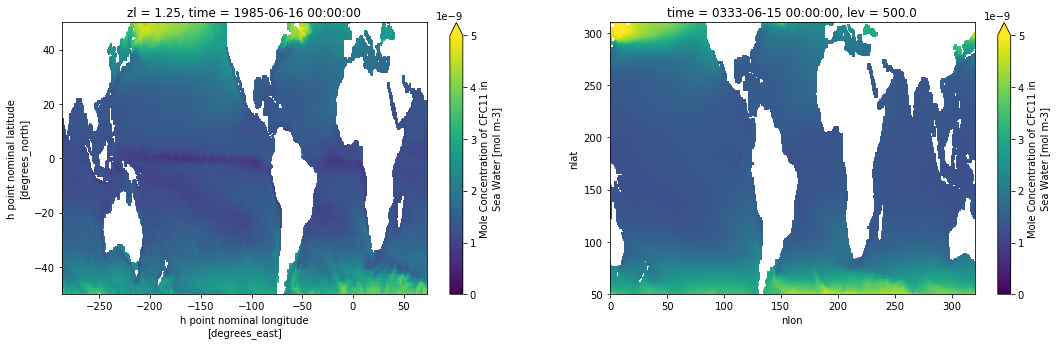

In [7]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,5))
ds_mom.CFC11[0,0,:].plot(ax=ax[0],vmin=0,vmax=5e-9)
cfc1_omip2.cfc11.plot(ax=ax[1],vmin=0,vmax=5e-9)
ax[0].set_ylim(-50,50)
ax[1].set_ylim(50,310)

### SST (June, 1985)

(45, 320)

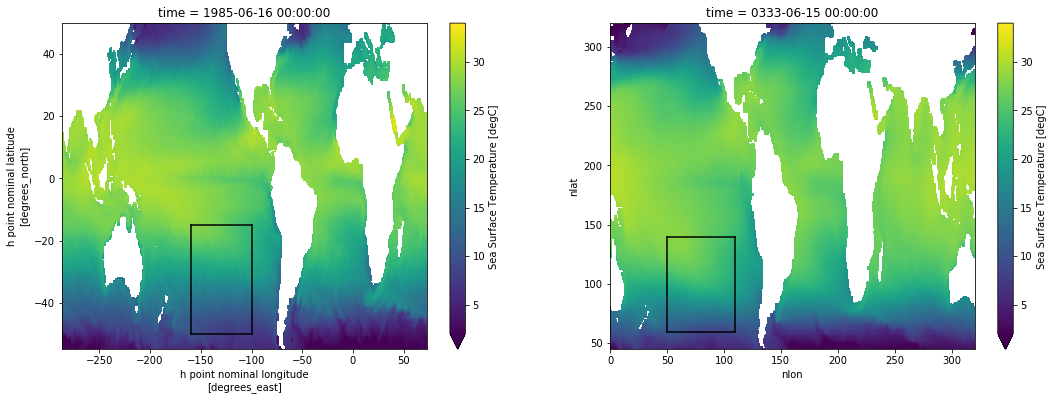

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
ds_mom.tos[0,:].plot(ax=ax[0],vmin=2,vmax=34)
sst_omip2.tos.plot(ax=ax[1],vmin=2,vmax=34)

############
# Using indeces in POP. Not trying to be super precise here...
############
# MOM
lons=[-160,-100]
lats=[-50,-15]
ax[0].plot(lons,[lats[0],lats[0]],'k')
ax[0].plot(lons,[lats[1],lats[1]],'k')
ax[0].plot([lons[0],lons[0]],lats,'k')
ax[0].plot([lons[1],lons[1]],lats,'k')
# POP
lonsp=[50,110]
latsp=[60,140]
ax[1].plot(lonsp,[latsp[0],latsp[0]],'k')
ax[1].plot(lonsp,[latsp[1],latsp[1]],'k')
ax[1].plot([lonsp[0],lonsp[0]],latsp,'k')
ax[1].plot([lonsp[1],lonsp[1]],latsp,'k')

ax[0].set_ylim(-55,50)
ax[1].set_ylim(45,320)


### SST vs CFC11 in the S. Pacific sub-tropical gyre

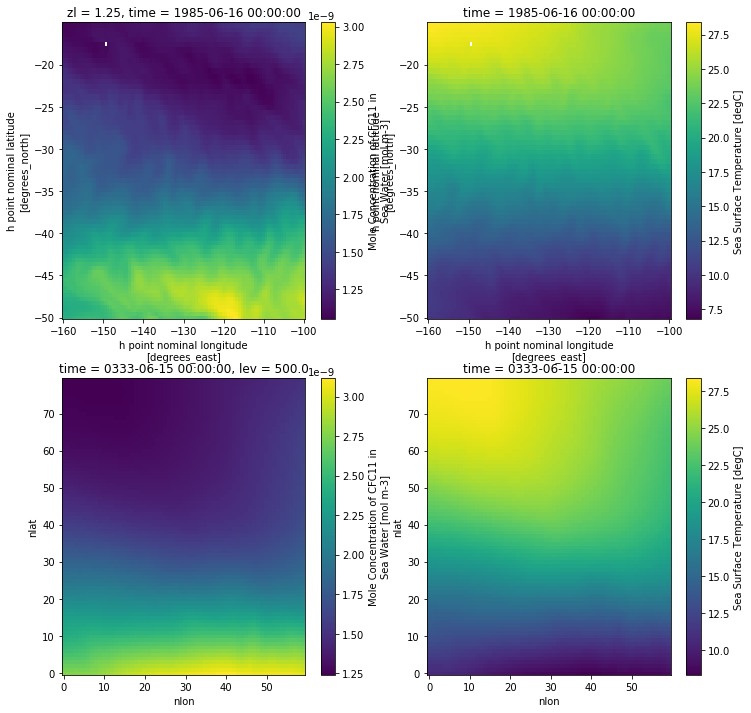

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
ax1=ax.flatten()
# MOM
ds_mom.CFC11[0,0,:].sel(xh=slice(lons[0], lons[1])).sel(yh=slice(lats[0], lats[1])).plot(ax=ax1[0])
ds_mom.tos[0,:].sel(xh=slice(lons[0], lons[1])).sel(yh=slice(lats[0], lats[1])).plot(ax=ax1[1])
# POP
cfc1_omip2.cfc11.sel(nlon=slice(lonsp[0], lonsp[1])).sel(nlat=slice(latsp[0], latsp[1])).plot(ax=ax1[2])
sst_omip2.tos.sel(nlon=slice(lonsp[0], lonsp[1])).sel(nlat=slice(latsp[0], latsp[1])).plot(ax=ax1[3])


In [10]:
# MOM
mom_cfc11_sel = ds_mom.CFC11[0,0,:].sel(xh=slice(lons[0], lons[1])).sel(yh=slice(lats[0], lats[1]))
mom_tos_sel = ds_mom.tos[0,:].sel(xh=slice(lons[0], lons[1])).sel(yh=slice(lats[0], lats[1]))
# POP
pop_cfc11_sel = cfc1_omip2.cfc11.sel(nlon=slice(lonsp[0], lonsp[1])).sel(nlat=slice(latsp[0], latsp[1]))
pop_tos_sel = sst_omip2.tos.sel(nlon=slice(lonsp[0], lonsp[1])).sel(nlat=slice(latsp[0], latsp[1]))

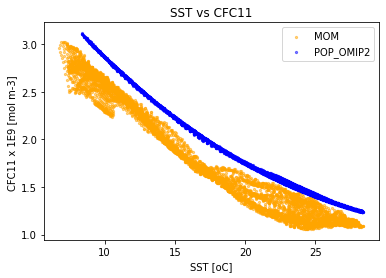

In [11]:
plt.scatter(mom_tos_sel.values.flatten(), mom_cfc11_sel.values.flatten()*1e9, 
            c='orange', alpha=0.5, s=5, label='MOM')
plt.scatter(pop_tos_sel.values.flatten(), pop_cfc11_sel.values.flatten()*1e9, 
            c='blue', alpha=0.5, s=5, label='POP_OMIP2')

plt.title('SST vs CFC11')
plt.xlabel('SST [oC]')
plt.ylabel('CFC11 x 1E9 [mol m-3] ')
plt.legend()
plt.show()

### SST vs CFC11 in the N. Pacific sub-tropical gyre

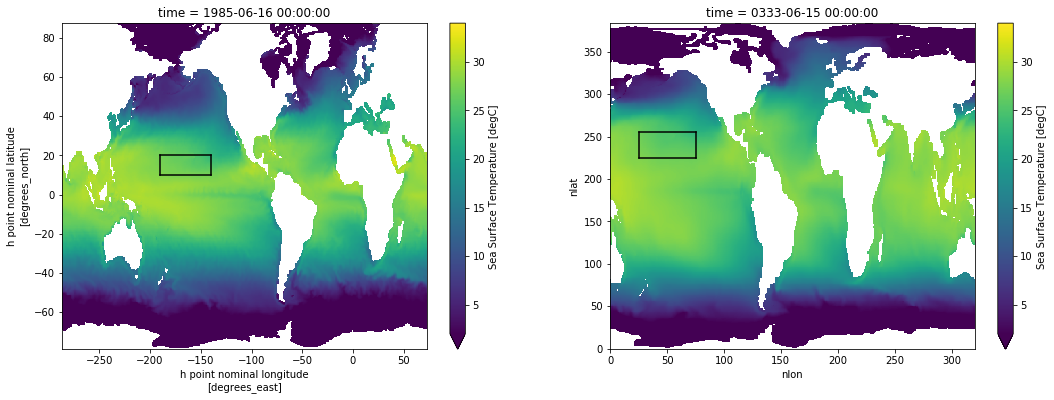

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
ds_mom.tos[0,:].plot(ax=ax[0],vmin=2,vmax=34)
sst_omip2.tos.plot(ax=ax[1],vmin=2,vmax=34)

############
# Using indeces in POP. Not trying to be super precise here...
############
# MOM
lons=[-190,-140]
lats=[10,20]
ax[0].plot(lons,[lats[0],lats[0]],'k')
ax[0].plot(lons,[lats[1],lats[1]],'k')
ax[0].plot([lons[0],lons[0]],lats,'k')
ax[0].plot([lons[1],lons[1]],lats,'k')
# POP
lonsp=[25,75]
latsp=[225,255]
ax[1].plot(lonsp,[latsp[0],latsp[0]],'k')
ax[1].plot(lonsp,[latsp[1],latsp[1]],'k')
ax[1].plot([lonsp[0],lonsp[0]],latsp,'k')
ax[1].plot([lonsp[1],lonsp[1]],latsp,'k')

#ax[0].set_ylim(0,30)
#ax[1].set_ylim(200,320)


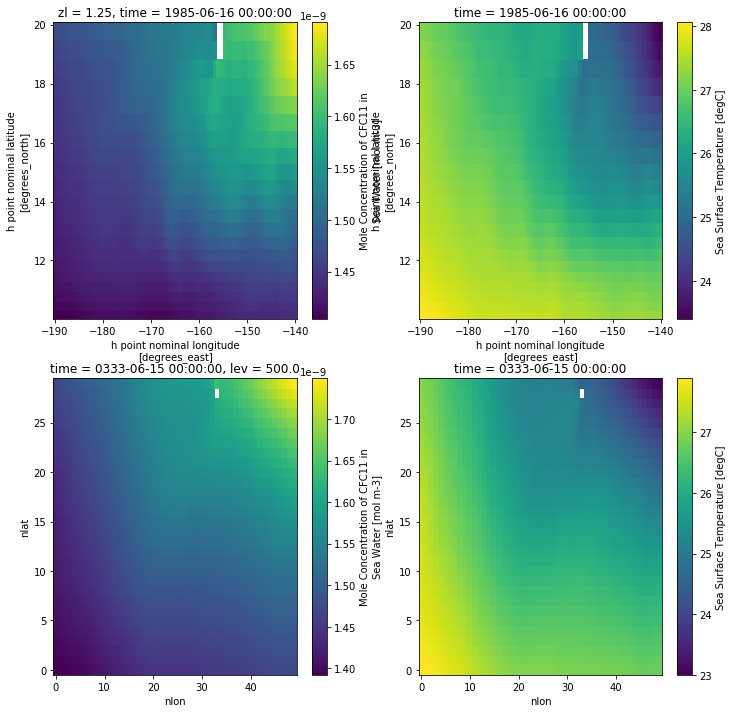

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
ax1=ax.flatten()
# MOM
ds_mom.CFC11[0,0,:].sel(xh=slice(lons[0], lons[1])).sel(yh=slice(lats[0], lats[1])).plot(ax=ax1[0])
ds_mom.tos[0,:].sel(xh=slice(lons[0], lons[1])).sel(yh=slice(lats[0], lats[1])).plot(ax=ax1[1])
# POP
cfc1_omip2.cfc11.sel(nlon=slice(lonsp[0], lonsp[1])).sel(nlat=slice(latsp[0], latsp[1])).plot(ax=ax1[2])
sst_omip2.tos.sel(nlon=slice(lonsp[0], lonsp[1])).sel(nlat=slice(latsp[0], latsp[1])).plot(ax=ax1[3])


In [26]:
# MOM
mom_cfc11_sel = ds_mom.CFC11[0,0,:].sel(xh=slice(lons[0], lons[1])).sel(yh=slice(lats[0], lats[1]))
mom_tos_sel = ds_mom.tos[0,:].sel(xh=slice(lons[0], lons[1])).sel(yh=slice(lats[0], lats[1]))
# POP
pop_cfc11_sel = cfc1_omip2.cfc11.sel(nlon=slice(lonsp[0], lonsp[1])).sel(nlat=slice(latsp[0], latsp[1]))
pop_tos_sel = sst_omip2.tos.sel(nlon=slice(lonsp[0], lonsp[1])).sel(nlat=slice(latsp[0], latsp[1]))

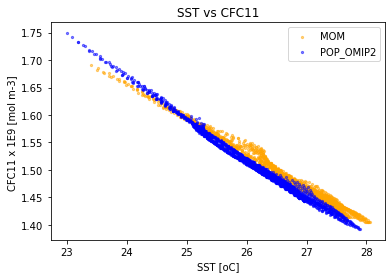

In [27]:
plt.scatter(mom_tos_sel.values.flatten(), mom_cfc11_sel.values.flatten()*1e9, 
            c='orange', alpha=0.5, s=5, label='MOM')
plt.scatter(pop_tos_sel.values.flatten(), pop_cfc11_sel.values.flatten()*1e9, 
            c='blue', alpha=0.5, s=5, label='POP_OMIP2')

plt.title('SST vs CFC11')
plt.xlabel('SST [oC]')
plt.ylabel('CFC11 x 1E9 [mol m-3] ')
plt.legend()
plt.show()